*Read section 8.1.2 of the book before using these notes.*

*Note that in this course, lecture notes are not sufficient, you must read the book for better understanding. Lecture notes are just implementing the concepts of the book on a dataset, but not explaining the concepts elaborately.*

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score,train_test_split, cross_val_predict
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

#Libraries for visualizing trees
from sklearn.tree import export_graphviz 
from six import StringIO
from IPython.display import Image  
import pydotplus

import time as time

In [2]:
train = pd.read_csv('./Datasets/diabetes_train.csv')
test = pd.read_csv('./Datasets/diabetes_test.csv')

In [3]:
test.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,2,197,70,45,543,30.5,0.158,53,1
2,1,115,70,30,96,34.6,0.529,32,1
3,8,99,84,0,0,35.4,0.388,50,0
4,7,147,76,0,0,39.4,0.257,43,1


## Building a classification tree
Develop a classification tree to predict if a person has diabetes.

In [3]:
X = train.drop(columns = 'Outcome')
Xtest = test.drop(columns = 'Outcome')
y = train['Outcome']
ytest = test['Outcome']

In [5]:
#Defining the object to build a classification tree
model = DecisionTreeClassifier(random_state=1, max_depth=3) 

#Fitting the regression tree to the data
model.fit(X, y)

DecisionTreeClassifier(max_depth=3, random_state=1)

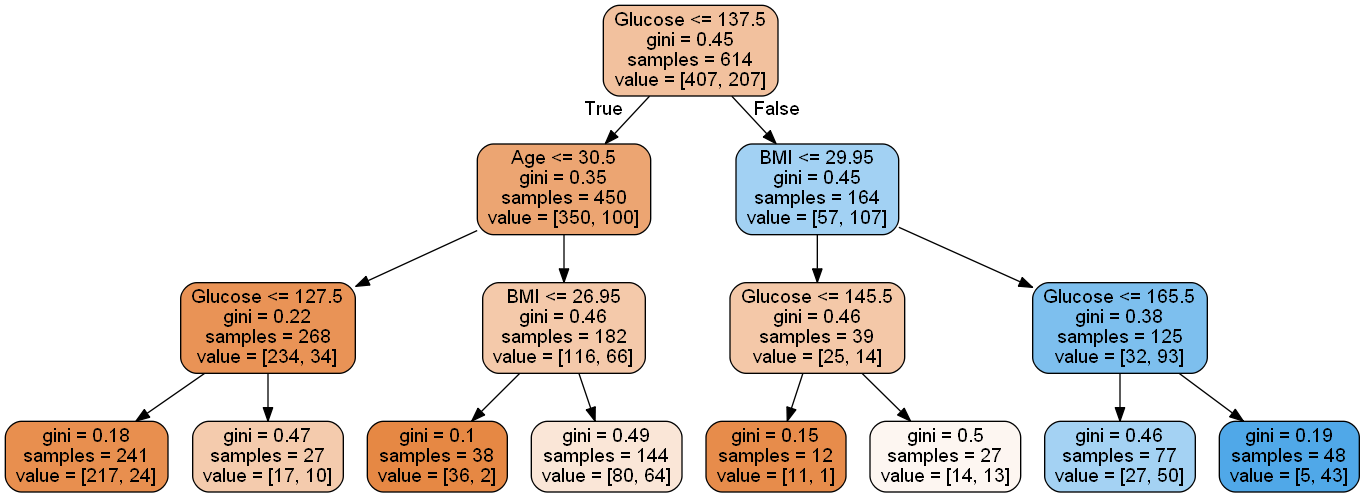

In [9]:
#Visualizing the regression tree
dot_data = StringIO()
export_graphviz(model, out_file=dot_data,  
                filled=True, rounded=True,
                feature_names =X.columns,precision=2)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
#graph.write_png('car_price_tree.png')
Image(graph.create_png())

Accuracy:  73.37662337662337
ROC-AUC:  0.8349197955226512
Precision:  0.7777777777777778
Recall:  0.45901639344262296


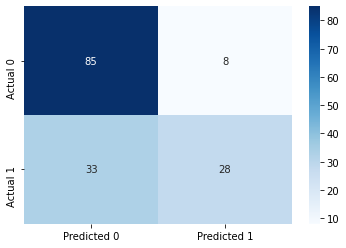

In [10]:
# Performance metrics computation 

#Computing the accuracy
y_pred = model.predict(Xtest)
print("Accuracy: ",accuracy_score(y_pred, ytest)*100)  

#Computing the ROC-AUC
y_pred_prob = model.predict_proba(Xtest)[:,1]
fpr, tpr, auc_thresholds = roc_curve(ytest, y_pred_prob)
print("ROC-AUC: ",auc(fpr, tpr))# AUC of ROC

#Computing the precision and recall
print("Precision: ", precision_score(ytest, y_pred))
print("Recall: ", recall_score(ytest, y_pred))

#Confusion matrix
cm = pd.DataFrame(confusion_matrix(ytest, y_pred), columns=['Predicted 0', 'Predicted 1'], 
            index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g');

## Optimizing hyperparameters to optimize performance
In case of diabetes, it is important to reduce FNR (False negative rate) or maximize recall. This is because if a person has diabetes, the consequences of predicting that they don't have diabetes can be much worse than the other way round.

Let us find the optimal depth of the tree and the number of terminal nods (leaves) that minimizes the FNR or maximizes recall.

Find the maximum values of depth and number of leaves.

In [4]:
#Defining the object to build a regression tree
model = DecisionTreeClassifier(random_state=1) 

#Fitting the regression tree to the data
model.fit(X, y)

DecisionTreeClassifier(random_state=1)

In [5]:
# Maximum number of leaves
model.get_n_leaves()

118

In [6]:
# Maximum depth
model.get_depth()

14

In [7]:
#Defining parameters and the range of values over which to optimize
param_grid = {    
    'max_depth': range(2,14),
    'max_leaf_nodes': range(2,118),
    'max_features': range(1, 9)
}

In [8]:
#Grid search to optimize parameter values

start_time = time.time()
skf = StratifiedKFold(n_splits=5)#The folds are made by preserving the percentage of samples for each class.

#Minimizing FNR is equivalent to maximizing recall
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=1), param_grid, scoring=['precision','recall'], 
                           refit="recall", cv=skf, n_jobs=-1, verbose = True)
grid_search.fit(X, y)

# make the predictions
y_pred = grid_search.predict(Xtest)

print('Train accuracy : %.3f'%grid_search.best_estimator_.score(X, y))
print('Test accuracy : %.3f'%grid_search.best_estimator_.score(Xtest, ytest))
print('Best recall Through Grid Search : %.3f'%grid_search.best_score_)

print('Best params for recall')
print(grid_search.best_params_)

print("Time taken =", round((time.time() - start_time)), "seconds")

Fitting 5 folds for each of 11136 candidates, totalling 55680 fits
Train accuracy : 0.785
Test accuracy : 0.675
Best recall Through Grid Search : 0.658
Best params for recall
{'max_depth': 4, 'max_features': 2, 'max_leaf_nodes': 8}
Time taken = 70 seconds


## Optimizing the decision threshold probability

Note that decision threshold probability is not tuned with `GridSearchCV` because `GridSearchCV` is a technique used for hyperparameter tuning in machine learning models, and the decision threshold probability is not a hyperparameter of the model.

The decision threshold is set to 0.5 by default during hyperparameter tuning with `GridSearchCV`.

`GridSearchCV` is used to tune hyperparameters that control the internal settings of a machine learning model, such as learning rate, regularization strength, and maximum tree depth, among others. These hyperparameters affect the model's internal behavior and performance. On the other hand, the decision threshold is an external parameter that is used to interpret the model's output and make predictions based on the predicted probabilities.

To tune the decision threshold, one typically needs to manually adjust it after the model has been trained and evaluated using a specific set of hyperparameter values. This can be done using methods, which involve evaluating the model's performance at different decision threshold values and selecting the one that best meets the desired trade-off between false positives and false negatives based on the specific problem requirements. 

As the recall will always be 100% for a decision threshold probability of zero, we'll find a decision threshold probability that balances recall with another performance metric such as precision, false positive rate, accuracy, etc. Below are a couple of examples that show we can balance recall with (1) precision or (2) false positive rate.

### Balancing recall with precision
We can find a threshold probability that balances recall with precision.

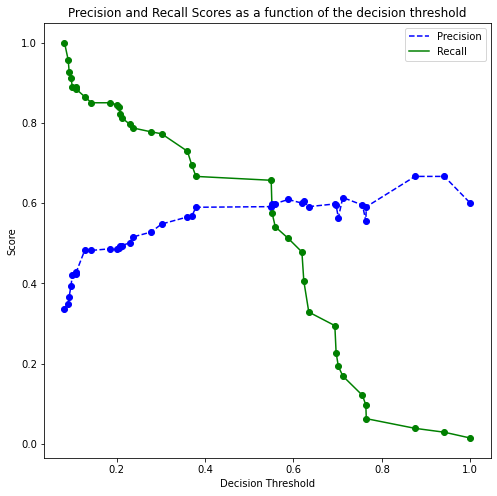

In [52]:
model = DecisionTreeClassifier(random_state=1, max_depth = 4, max_leaf_nodes=8, max_features=2).fit(X, y)

# Note that we are using the cross-validated predicted probabilities, instead of directly using the 
# predicted probabilities on train data, as the model may be overfitting on the train data, and 
# may lead to misleading results
cross_val_ypred = cross_val_predict(DecisionTreeClassifier(random_state=1, max_depth = 4, 
                                                        max_leaf_nodes=8, max_features=2), X, 
                                              y, cv = 5, method = 'predict_proba')

p, r, thresholds = precision_recall_curve(y, cross_val_ypred[:,1])
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.plot(thresholds, precisions[:-1], "o", color = 'blue')
    plt.plot(thresholds, recalls[:-1], "o", color = 'green')
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')
    plt.legend()
plot_precision_recall_vs_threshold(p, r, thresholds)

In [53]:
# Thresholds with precision and recall
np.concatenate([thresholds.reshape(-1,1), p[:-1].reshape(-1,1), r[:-1].reshape(-1,1)], axis = 1)

array([[0.08196721, 0.33713355, 1.        ],
       [0.09045226, 0.34982332, 0.95652174],
       [0.09248555, 0.36641221, 0.92753623],
       [0.0964467 , 0.39293139, 0.91304348],
       [0.1       , 0.42105263, 0.88888889],
       [0.10810811, 0.42298851, 0.88888889],
       [0.10869565, 0.42857143, 0.88405797],
       [0.12820513, 0.48378378, 0.8647343 ],
       [0.14285714, 0.48219178, 0.85024155],
       [0.18518519, 0.48618785, 0.85024155],
       [0.2       , 0.48611111, 0.84541063],
       [0.20512821, 0.48876404, 0.84057971],
       [0.20833333, 0.49418605, 0.82125604],
       [0.21276596, 0.49411765, 0.8115942 ],
       [0.22916667, 0.50151976, 0.79710145],
       [0.23684211, 0.51582278, 0.78743961],
       [0.27777778, 0.52786885, 0.77777778],
       [0.3015873 , 0.54794521, 0.77294686],
       [0.36      , 0.56554307, 0.7294686 ],
       [0.3697479 , 0.56692913, 0.69565217],
       [0.37931034, 0.58974359, 0.66666667],
       [0.54954955, 0.59130435, 0.65700483],
       [0.

Suppose, we wish to have at least 80% recall, with the highest possible precision. Then, based on the precision-recall curve *(or the table above)*, we should have a decision threshold probability of 0.21.

Let's assess the model's performance on test data with a threshold probability of 0.21.

Accuracy:  72.72727272727273
ROC-AUC:  0.7544509078089194
Precision:  0.611764705882353
Recall:  0.8524590163934426


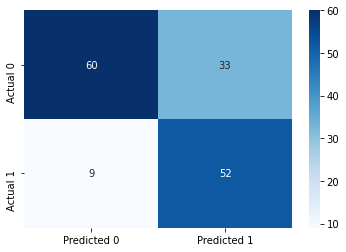

In [54]:
# Performance metrics computation for the optimum decision threshold probability
desired_threshold = 0.21

y_pred_prob = model.predict_proba(Xtest)[:,1] 

# Classifying observations in the positive class (y = 1) if the predicted probability is greater
# than the desired decision threshold probability
y_pred = y_pred_prob > desired_threshold
y_pred = y_pred.astype(int)

#Computing the accuracy
print("Accuracy: ",accuracy_score(y_pred, ytest)*100)  

#Computing the ROC-AUC
fpr, tpr, auc_thresholds = roc_curve(ytest, y_pred_prob)
print("ROC-AUC: ",auc(fpr, tpr))# AUC of ROC

#Computing the precision and recall
print("Precision: ", precision_score(ytest, y_pred))
print("Recall: ", recall_score(ytest, y_pred))

#Confusion matrix
cm = pd.DataFrame(confusion_matrix(ytest, y_pred), 
                  columns=['Predicted 0', 'Predicted 1'], index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g');

### Balancing recall with false positive rate

Suppose we wish to balance recall with false positive rate. We can optimize the model to maximize ROC-AUC, and then choose a point on the ROC-curve that balances recall with the false positive rate.

In [55]:
# Defining parameters and the range of values over which to optimize
param_grid = {    
    'max_depth': range(2,14),
    'max_leaf_nodes': range(2,118),
    'max_features': range(1, 9)
}

In [56]:
#Grid search to optimize parameter values

start_time = time.time()
skf = StratifiedKFold(n_splits=5)#The folds are made by preserving the percentage of samples for each class.

#Minimizing FNR is equivalent to maximizing recall
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=1), param_grid, scoring=['precision','recall',
                            'roc_auc'], refit="roc_auc", cv=skf, n_jobs=-1, verbose = True)
grid_search.fit(X, y)

# make the predictions
y_pred = grid_search.predict(Xtest)

print('Best params for recall')
print(grid_search.best_params_)

print("Time taken =", round((time.time() - start_time)), "seconds")

Fitting 5 folds for each of 11136 candidates, totalling 55680 fits
Best params for recall
{'max_depth': 6, 'max_features': 2, 'max_leaf_nodes': 9}
Time taken = 72 seconds


In [57]:
model = DecisionTreeClassifier(random_state=1, max_depth = 6, max_leaf_nodes=9, max_features=2).fit(X, y)

0.7605075431162388


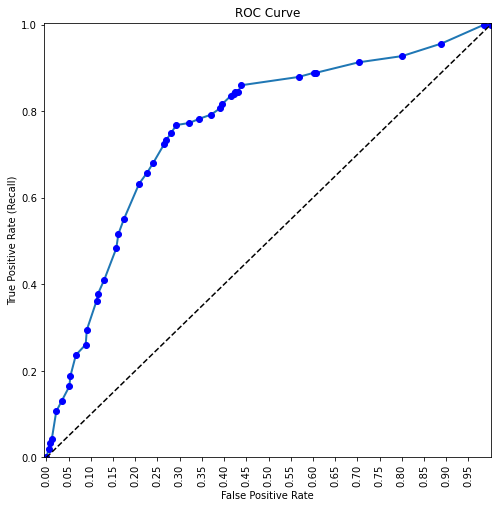

In [58]:
cross_val_ypred = cross_val_predict(DecisionTreeClassifier(random_state=1, max_depth = 6, 
                                                           max_leaf_nodes=9, max_features=2), X, 
                                              y, cv = 5, method = 'predict_proba')

fpr, tpr, auc_thresholds = roc_curve(y, cross_val_ypred[:,1])
print(auc(fpr, tpr))# AUC of ROC
def plot_roc_curve(fpr, tpr, label=None):
    plt.figure(figsize=(8,8))
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot(fpr, tpr, 'o', color = 'blue')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.005, 1, 0, 1.005])
    plt.xticks(np.arange(0,1, 0.05), rotation=90)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")

fpr, tpr, auc_thresholds = roc_curve(y, cross_val_ypred[:,1])
plot_roc_curve(fpr, tpr)

In [59]:
# Thresholds with TPR and FPR
all_thresholds = np.concatenate([auc_thresholds.reshape(-1,1), tpr.reshape(-1,1), fpr.reshape(-1,1)], axis = 1)
recall_more_than_80 = all_thresholds[all_thresholds[:,1]>0.8,:]
# As the values in 'recall_more_than_80' are arranged in increasing order of recall and decreasing threshold,
# the first value will provide the maximum threshold probability for the recall to be more than 80%
# We wish to find the maximum threshold probability to obtain the minimum possible FPR
recall_more_than_80[0]

array([0.21276596, 0.80676329, 0.39066339])

Suppose, we wish to have at least 80% recall, with the lowest possible precision. Then, based on the ROC-AUC curve, we should have a decision threshold probability of 0.21.

Let's assess the model's performance on test data with a threshold probability of 0.21.

Accuracy:  71.42857142857143
ROC-AUC:  0.7618543980257358
Precision:  0.6075949367088608
Recall:  0.7868852459016393


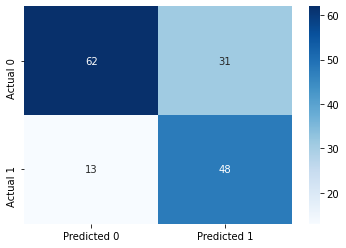

In [65]:
# Performance metrics computation for the optimum decision threshold probability
desired_threshold = 0.21

y_pred_prob = model.predict_proba(Xtest)[:,1] 

# Classifying observations in the positive class (y = 1) if the predicted probability is greater
# than the desired decision threshold probability
y_pred = y_pred_prob > desired_threshold
y_pred = y_pred.astype(int)

#Computing the accuracy
print("Accuracy: ",accuracy_score(y_pred, ytest)*100)  

#Computing the ROC-AUC
fpr, tpr, auc_thresholds = roc_curve(ytest, y_pred_prob)
print("ROC-AUC: ",auc(fpr, tpr))# AUC of ROC

#Computing the precision and recall
print("Precision: ", precision_score(ytest, y_pred))
print("Recall: ", recall_score(ytest, y_pred))

#Confusion matrix
cm = pd.DataFrame(confusion_matrix(ytest, y_pred), 
                  columns=['Predicted 0', 'Predicted 1'], index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g');

## Cost complexity pruning
Just as we did cost complexity pruning in a regression tree, we can do it to optimize the model for a classification tree.

In [129]:
model = DecisionTreeClassifier(random_state = 1)#model without any restrictions
path= model.cost_complexity_pruning_path(X,y)# Compute the pruning path during Minimal Cost-Complexity Pruning.

In [130]:
alphas=path['ccp_alphas']
len(alphas)

58

In [131]:
#Grid search to optimize parameter values

skf = StratifiedKFold(n_splits=5)
grid_search = GridSearchCV(DecisionTreeClassifier(random_state = 1), param_grid = {'ccp_alpha':alphas}, 
                                                  scoring=['precision','recall','accuracy'], 
                                                  refit="recall", cv=skf, n_jobs=-1, verbose = True)
grid_search.fit(X, y)

# make the predictions
y_pred = grid_search.predict(Xtest)

print('Best params for recall')
print(grid_search.best_params_)

Fitting 5 folds for each of 58 candidates, totalling 290 fits
Best params for recall
{'ccp_alpha': 0.010561291712538737}


In [134]:
# Model with the optimal value of 'ccp_alpha'
model = DecisionTreeClassifier(ccp_alpha=0.01435396,random_state=1)
model.fit(X, y)

DecisionTreeClassifier(ccp_alpha=0.01435396, random_state=1)

Now we can tune the decision threshold probability to balance recall with another performance metrics as shown earlier in [Section 4.3](https://nustat.github.io/STAT303-3-class-notes/Lec4_ClassificationTree.html#optimizing-the-decision-threshold-probability).